<a href="https://colab.research.google.com/github/arielbakal/vehicle_routing_problem/blob/main/vehicle_routing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def generate_locations(depot_coord, locations_quantity, map_limit):

  x_components = np.random.randint(map_limit[0], map_limit[1], size=locations_quantity)
  y_components = np.random.randint(map_limit[0], map_limit[1], size=locations_quantity)
  locations = [np.array([x, y]) for x, y in zip(x_components, y_components)]

  return locations

Generating a list of $(x,y)$ random points

In [ ]:
def routing( depot_coord, locations ):

  locations_local = locations[:]
  location_from = depot_coord
  routes = []

  while len(locations_local) != 0:
    location_index = np.argmin( [np.linalg.norm( location_from - location ) for location in locations_local] )
    location_to = locations_local[ location_index ]
    routes.append([location_from,location_to])
    location_from = location_to
    locations_local.pop(location_index)

  routes = routes + [ [routes[-1][1] , depot_coord] ]

  return routes

  Then i start tracing routes between the start point and its closest point, then the next closest point and so on, until it ends out of points and ends at the starting point

In [ ]:
def map_routes(routes):

  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  x_coords = [point[0] for route in routes for point in route]
  y_coords = [point[1] for route in routes for point in route]

  for route in routes:
      axs[1].arrow(route[0][0], route[0][1], route[1][0] - route[0][0], route[1][1] - route[0][1], color='gray', width=0.025, length_includes_head=True, head_width=1.5)
      axs[1].plot([route[0][0], route[1][0]], [route[0][1], route[1][1]], color='gray')

  axs[1].scatter(x_coords[:-2], y_coords[:-2], label='Locations')
  axs[1].scatter(x_coords[-2:][1], y_coords[-2:][1], label='Depot')
  axs[1].set_xlabel('X')
  axs[1].set_ylabel('Y')
  axs[1].set_title('Routes')

  axs[0].scatter(x_coords[:-2], y_coords[:-2], label='Locations')
  axs[0].scatter(x_coords[-2:][1], y_coords[-2:][1], label='Depot')
  axs[0].set_xlabel('X')
  axs[0].set_ylabel('Y')
  axs[0].set_title('Map')

  plt.tight_layout()
  plt.legend()
  plt.show()

At first, i plot a Map with all the points and then the Routes Map

In [ ]:
def run_algorithm( depot_coord, locations_quantity, map_limit ):

  locations_local = generate_locations( depot_coord, locations_quantity, map_limit )
  routes = routing( depot_coord, locations_local )
  map_routes(routes)

Lastly, i need a function whichs runs the whole algorithm

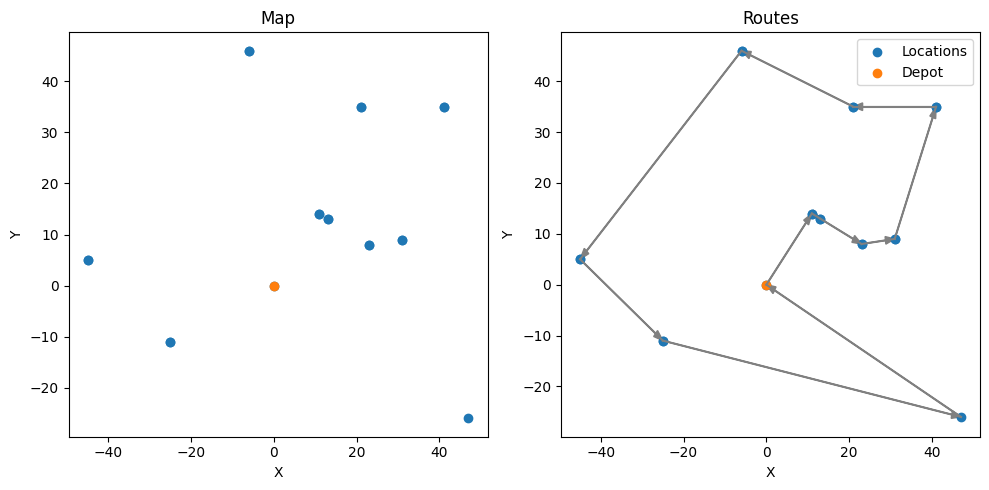

In [ ]:
run_algorithm( (0,0), 10, (-50,50) )

This should be enough to understand what we are willing to achieved.

Here we are working with cartesian points, but we aren't positioned on a plane map. As we are on a non-perfect sphere, i'll be talking about latitude and longitude.

These are their limits:

$latitude \in [-90,90]$
, $longitude \in [-180,180]$

In [ ]:
def generate_geolocations(depot_coord, locations_quantity):

    lat_components = np.random.uniform(-90, 90, size=locations_quantity)
    lon_components = np.random.uniform(-180, 180, size=locations_quantity)

    locations = [np.array([lat, lon]) for lat, lon in zip(lat_components, lon_components)]

    return locations

Since we are in a non-perfect sphere, we cant do euclidean distance anymore. Instead, we've to do some trigonometric calculations, like using the Haversine formula whichs calculates the distance between two points on a sphere.

You can build a function for this, but there is a python library who does this work for us.

In [ ]:
from geopy.distance import geodesic

Adapting our routing function

In [ ]:
def georouting( depot_coord, locations ):

  locations_local = locations[:]
  location_from = depot_coord
  routes = []

  while len(locations_local) != 0:
    location_index = np.argmin( [geodesic(location_from, location).kilometers for location in locations_local] )
    location_to = locations_local[ location_index ]
    routes.append([location_from,location_to])
    location_from = location_to
    locations_local.pop(location_index)

  routes = routes + [ [routes[-1][1] , depot_coord] ]

  return routes

In [ ]:
def run_algorithm( depot_coord, locations_quantity ):

  locations_local = generate_geolocations( depot_coord, locations_quantity )
  routes = georouting( depot_coord, locations_local )
  map_routes(routes)

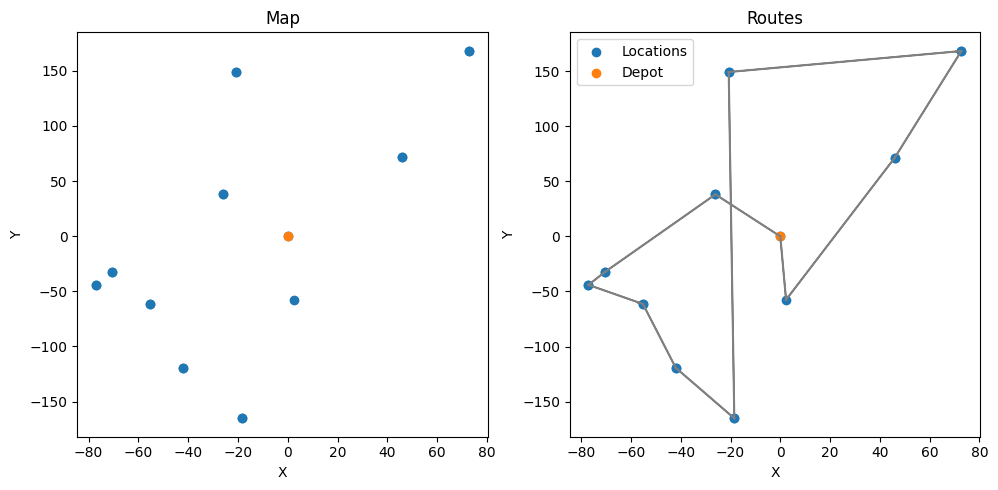

In [ ]:
run_algorithm( (0,0), 10 )

This routes may look wrong, but we are representing our sphere points as plane poitns.

Lets import a bigger set of locations

In [1]:
import pandas as pd

In [2]:
file_path = "/content/sample_data/data.json"

df = pd.read_json(file_path)

In [7]:
print(df)

         id    latitud     longitud
0    639933 -32.622739   -60.144791
1    639941 -34.810421  -58.1743186
2    639942 -34.863270  -58.1832665
3    640436 -31.537500    -68.53639
4    640438 -34.610164  -58.9564347
..      ...        ...          ...
516  642262 -31.435560    -62.07139
517  642263 -32.941525   -60.665639
518  642264 -31.241309   -64.466576
519  642265 -31.416670    -64.18333
520  642266 -31.662700     -60.7653

[521 rows x 3 columns]


Here we have 521 locations

In [8]:
depot_coord = tuple(df.loc[0])
locations = [tuple(df.loc[i]) for i in range(1, df.shape[0])]

We have to adapt our routing function, since we have 3-tuples

In [ ]:
def georouting( depot_coord, locations ):

  locations_local = locations[:]
  location_from = depot_coord
  routes = []

  while len(locations_local) != 0:
    location_index = np.argmin( [geodesic(location_from[1:], location[1:]).kilometers for location in locations_local] )
    location_to = locations_local[ location_index ]
    routes.append([location_from,location_to])
    location_from = location_to
    locations_local.pop(location_index)

  routes = routes + [ [routes[-1][1] , depot_coord] ]

  return routes

Now, lets play the role of being a service. Since we get a json file, lets return a json with all the routes

In [9]:
import json